In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit

In [3]:
def file_parser(filename):
    IS_DATA = False

    #the function will fill and return these dictionaries:
    header_dict = {
        "Keys": [],
        "Key Info": []
    }

    spectrum_dict = {
        "bins": [], 
        "counts": []
    }

    with open(filename, "r") as file:
        for line in file:
            line = line.strip()

        # if it's data, reset the flag
            if line == '$DATA:':
                IS_DATA = True
                continue
            elif line.startswith('$'):
                header_dict["Keys"].append(line)
                next_line = next(file).strip()
                header_dict["Key Info"].append(next_line)
                IS_DATA = False

        #this is for all lines following # DATA
        #while IS_DATA == True:  
            if IS_DATA == True:
                try:
                    spectrum_dict["counts"].append(float(line))
                    #w, f = list(map(float, line.split(',')))
                    #spectrum_dict["Wavelength"].append(float(w))
                    #spectrum_dict["Flux"].append(float(f))
                except ValueError:
                    continue   
    #change if bin range changes
    for i in range(1024):
        spectrum_dict["bins"].append(i)
        
    return header_dict, spectrum_dict

In [4]:
background_header, background_spec = file_parser("C:/Users/erisd/Desktop/Detector Lab/Background Files/Background_BGO.Spe")

In [5]:
background_header

{'Keys': ['$SPEC_ID:',
  '$SPEC_REM:',
  '$DATE_MEA:',
  '$MEAS_TIM:',
  '$ROI:',
  '$PRESETS:',
  '$ENER_FIT:',
  '$MCA_CAL:',
  '$SHAPE_CAL:'],
 'Key Info': ['No sample description was entered.',
  'DET# 2',
  '10/28/2025 11:03:46',
  '200 200',
  '0',
  'None',
  '0.000000 2.205567',
  '3',
  '3']}

In [6]:
background_header['Key Info'][3].split()

['200', '200']

In [7]:
real_time, live_time = background_header['Key Info'][3].split()
real_time = float(real_time)
live_time = float(live_time)
background_cps = np.array(background_spec['counts'])/real_time

Text(0, 0.5, 'Counts')

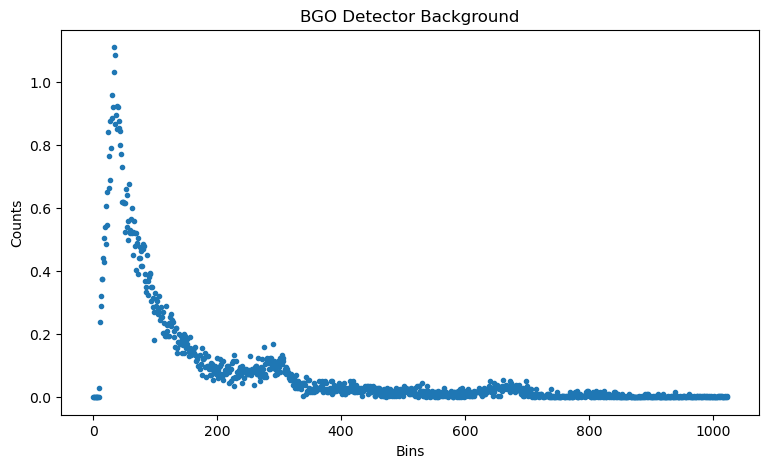

In [8]:
fig, ax = plt.subplots(figsize = (9,5))
ax.plot(background_spec['bins'],background_cps,'.')
ax.set_title('BGO Detector Background')
ax.set_xlabel('Bins')
ax.set_ylabel('Counts')

In [9]:
Ba_0degree_header, Ba_0degree_spec = file_parser('C:/Users/erisd/Desktop/Detector Lab/BGO Data/Ba_BGO.Spe')

In [10]:
Co_header, Co_spec = file_parser('C:/Users/erisd/Desktop/Detector Lab/BGO Data/Co BGO.Spe')

In [11]:
Cs_header, Cs_spec = file_parser('C:/Users/erisd/Desktop/Detector Lab/BGO Data/Cs_BGO_0.Spe')

In [12]:
Am_header, Am_spec = file_parser('C:/Users/erisd/Desktop/Detector Lab/BGO Data/AM BGO.Spe')

In [13]:
def data_fetcher(header,spec):
    real_time, live_time = header['Key Info'][3].split()
    real_time = float(real_time)
    cps = np.asarray(spec['counts'])/real_time
    
    cps -= background_cps
    bins = spec['bins']
    
    return cps, bins

In [16]:
Ba_0_cps, Ba_bins = data_fetcher(Ba_0degree_header,Ba_0degree_spec)

In [16]:
Cs_cps, Cs_bins = data_fetcher(Cs_header,Cs_spec)
Am_cps, Am_bins = data_fetcher(Am_header, Am_spec)
Co_cps, Co_bins = data_fetcher(Co_header,Co_spec)

Text(0, 0.5, 'counts/s')

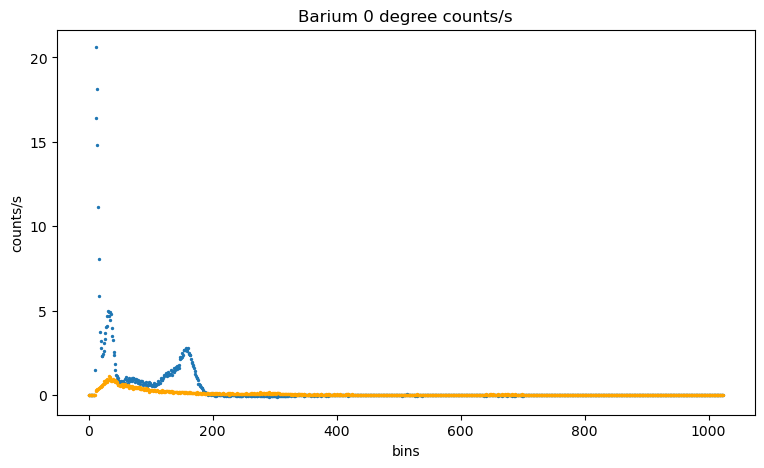

In [18]:
fig,ax = plt.subplots(figsize=(9,5))
ax.scatter(Ba_bins, Ba_0_cps,s=2)
ax.scatter(background_spec['bins'],background_cps,color='orange', s = 2)
ax.set_title('Barium 0 degree counts/s')
ax.set_xlabel('bins')
ax.set_ylabel('counts/s')

Text(0, 0.5, 'counts/s')

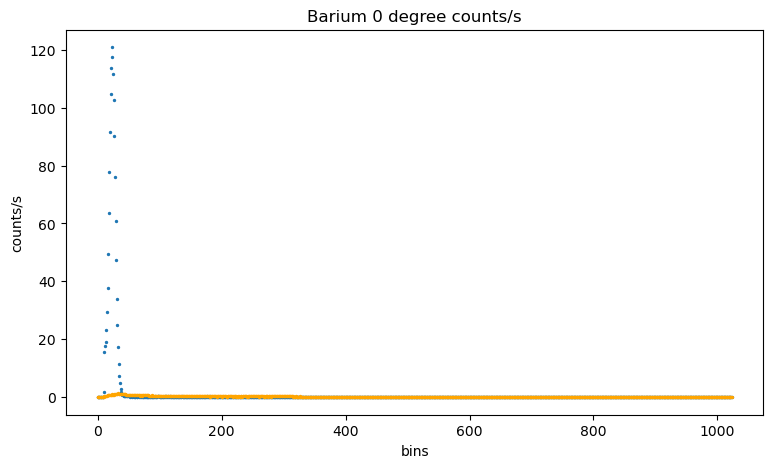

In [17]:
fig,ax = plt.subplots(figsize=(9,5))
ax.scatter(Am_bins, Am_cps,s=2)
ax.scatter(background_spec['bins'],background_cps,color='orange', s = 2)
ax.set_title('Barium 0 degree counts/s')
ax.set_xlabel('bins')
ax.set_ylabel('counts/s')

Text(0, 0.5, 'counts/s')

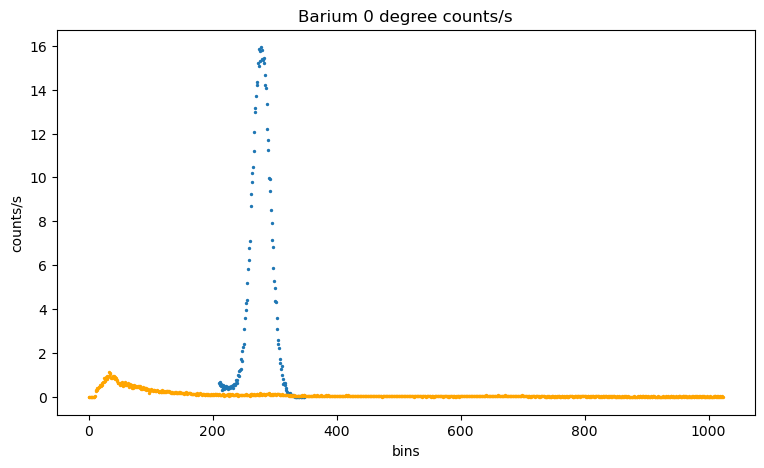

In [24]:
fig,ax = plt.subplots(figsize=(9,5))
ax.scatter(Cs_bins[210:350], Cs_cps[210:350],s=2)
ax.scatter(background_spec['bins'],background_cps,color='orange', s = 2)
ax.set_title('Barium 0 degree counts/s')
ax.set_xlabel('bins')
ax.set_ylabel('counts/s')

Text(0, 0.5, 'counts/s')

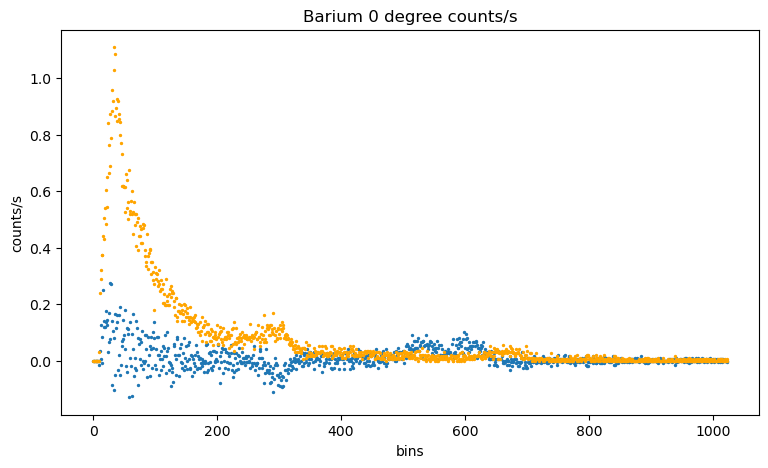

In [19]:
fig,ax = plt.subplots(figsize=(9,5))
ax.scatter(Co_bins, Co_cps,s=2)
ax.scatter(background_spec['bins'],background_cps,color='orange', s = 2)
ax.set_title('Barium 0 degree counts/s')
ax.set_xlabel('bins')
ax.set_ylabel('counts/s')

In [19]:
def ignore_peak(flux):
    """
    Function used to ignore the peak part of the data for plotting the baseline
    Input: y data (flux)
    Output: list of ajdusted y data, were values associated with the peak are replaced with mean flux
    """
    background_y = []
    mean_flux = np.mean(flux)
    flux_std = np.std(flux)
    for i in flux:
        if i > (1.5): #if the flux is higher than this, the point is probably part of the peak
            background_y.append(mean_flux)
        else:
            background_y.append(i)
    return background_y

def ignore_peak_Ba1(flux):
    """
    Function used to ignore the peak part of the data for plotting the baseline
    Input: y data (flux)
    Output: list of ajdusted y data, were values associated with the peak are replaced with mean flux
    """
    background_y = []
    mean_flux = np.mean(flux)
    flux_std = np.std(flux)
    for i in flux:
        if i > (1.5): #if the flux is higher than this, the point is probably part of the peak
            background_y.append(0.3)
        else:
            background_y.append(i)
    return background_y

In [20]:
#fitting functions: 
def quadratic(x, a, b, c):
    """A quatratic function, used for curve fitting"""
    return a * (x**2) + b * x + c

def gaussian(x, mu, sig, amp):
    """A Gaussian function, used for scipi curve fit"""
    return amp * np.exp(-0.5 * (x-mu)**2 / sig**2) / np.sqrt(2 * np.pi * sig**2)

def compound_model(x, mu, sig, amp, a, b, c):
    """combines the quadratic fit of the background with the Gaussian fit which better represents the peak"""
    return quadratic(x, a, b, c) + gaussian(x, mu, sig, amp)

def fit_compound_model(x, y, p0=None):
    """
    Function to fit data using curve_fit and compound_model
    Inputs: x, y (list of x, y data)
    Outputs: popt (parameters array), pcov (covarience array) 
    """

    #if no p0 is passed, guess: 

    if p0 is None: 
        A_guess = np.max(y) - np.min(y)
        mu_guess = np.sum(x * y) / np.sum(y)
        sigma_guess = (np.max(x) - np.min(x)) / 10
        #getting the polynomial parameters: 
        background_y = ignore_peak(y)
        b_popt, b_pcov = curve_fit(quadratic, x, background_y, p0 = None)

    p0 = [mu_guess, sigma_guess, A_guess, *b_popt]
    popt, pcov = curve_fit(compound_model, x, y, p0 = p0)

    return popt, pcov

def print_uncertainties(pcov, popt):
    """a function to print out the parameters and their uncertanties"""
    uncertainties = np.sqrt(np.diag(pcov))
    #[mu0, sig0, amp0, a, b, c] 
    print("Parameters: \n")
    print(f"Baseline Polynomial Fit: ")
    print(f"a = {popt[3]} +/- {uncertainties[3]},")
    print(f"b = {popt[4]} +/- {uncertainties[4]}, ")
    print(f"c = {popt[5]} +/- {uncertainties[5]}")
    print(f"Gaussian Fit: ")
    print(f"mu0 = {popt[0]} +/- {uncertainties[0]},")
    print(f"sigma0 = {popt[1]} +/- {uncertainties[1]},")
    print(f"amp0 = {popt[2]} +/- {uncertainties[2]}")



Text(0, 0.5, 'counts/s')

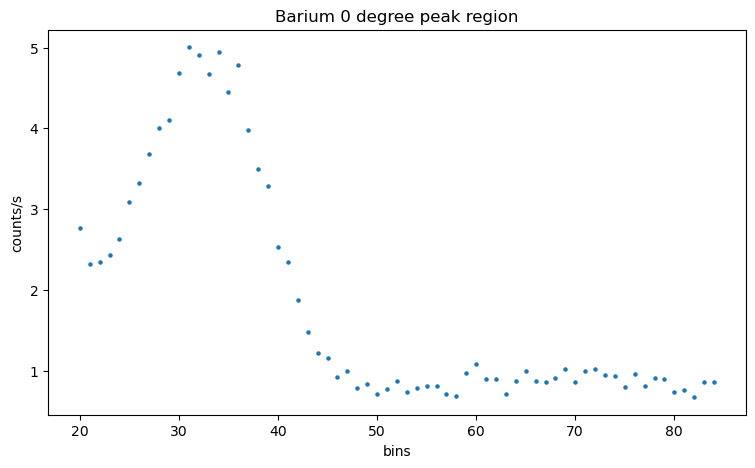

In [21]:
fig,ax = plt.subplots(figsize=(9,5))
ax.scatter(Ba_bins[20:85], Ba_0_cps[20:85],s=5)
ax.set_title('Barium 0 degree peak region')
ax.set_xlabel('bins')
ax.set_ylabel('counts/s')

In [22]:
ignore_peak_Ba = ignore_peak(Ba_0_cps[20:85])

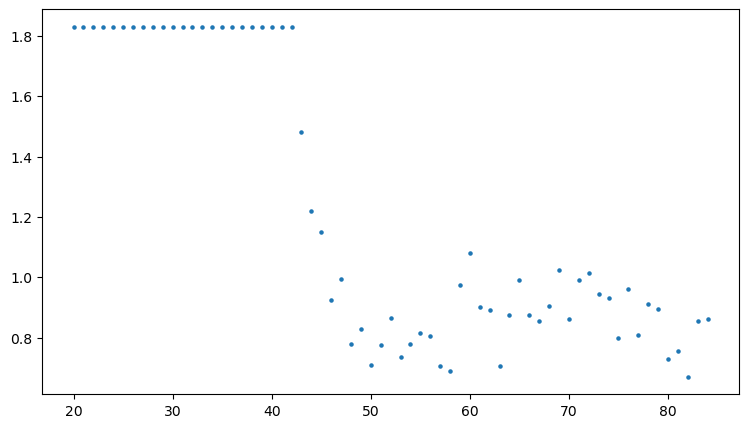

In [23]:
plt.close('all')
fig,ax = plt.subplots(figsize= (9,5))
ax.scatter(Ba_bins[20:85],ignore_peak_Ba,s=5)

In [24]:
#Ba_bins

In [25]:
peak_popt, peak_pcov = fit_compound_model(Ba_bins[20:85],Ba_0_cps[20:85])

In [26]:
background_y = ignore_peak(Ba_0_cps[20:85])
b_popt, b_pcov = curve_fit(quadratic, Ba_bins[20:85], background_y, p0 = None)
quad_fit = quadratic(np.array(Ba_bins[20:85]), *b_popt)

In [27]:
#Ba_bins

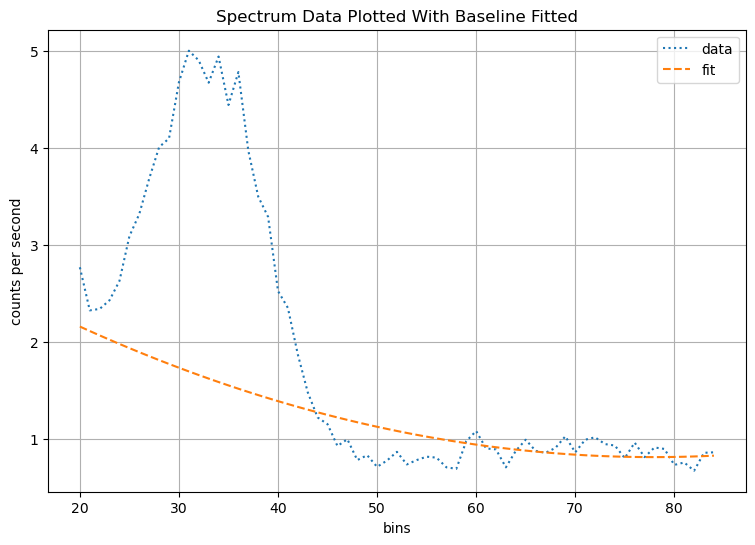

In [28]:
fig, ax = plt.subplots(figsize  = (9,6))
ax.set_title("Spectrum Data Plotted With Baseline Fitted")
ax.set_xlabel("bins")
ax.set_ylabel("counts per second")

ax.plot(Ba_bins[20:85], Ba_0_cps[20:85], ls = ":", label = "data")
ax.plot(Ba_bins[20:85], quad_fit, ls = '--', label = "fit")
ax.grid()
ax.legend()

Parameters: 

Baseline Polynomial Fit: 
a = 0.0007037560180025403 +/- 8.445495733375647e-05,
b = -0.09126004036388354 +/- 0.009885247467648182, 
c = 3.7190017383708023 +/- 0.29274372001363985
Gaussian Fit: 
mu0 = 33.00213777070017 +/- 0.1507486017635693,
sigma0 = 5.1923378151231105 +/- 0.19495955520417355,
amp0 = 46.11191170358221 +/- 2.3229981616563085


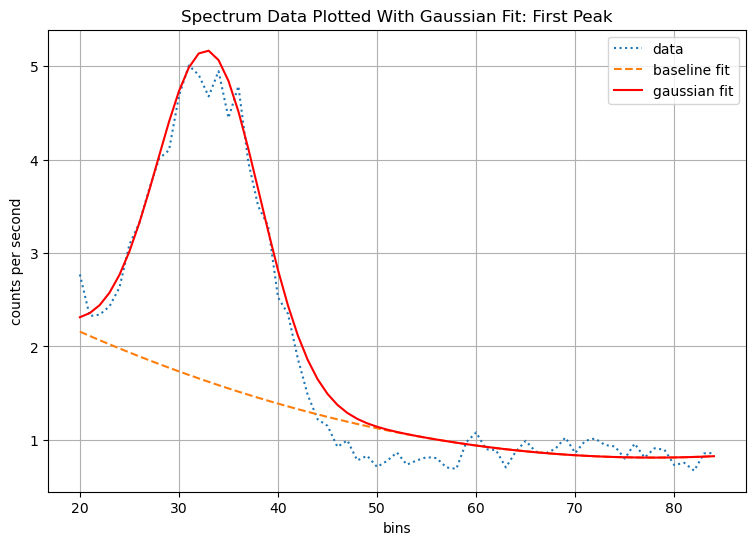

In [29]:
#fitting and plotting gauss model: 
popt, pcov = fit_compound_model(np.array(Ba_bins[20:85]), np.array(Ba_0_cps[20:85]))
#compound_fit = compound_model(np.array(spectrum_dict["Wavelength"]), *popt)
gauss_fit = gaussian(np.array(Ba_bins[20:85]), *popt[:3])
    
fig, ax = plt.subplots(figsize = (9,6))

ax.set_title("Spectrum Data Plotted With Gaussian Fit: First Peak")
ax.set_xlabel("bins")
ax.set_ylabel("counts per second")

ax.plot(Ba_bins[20:85], Ba_0_cps[20:85], ls = ":", label = "data")
ax.plot(Ba_bins[20:85], quad_fit, ls = '--', label = "baseline fit")
#for some reason the line below works better than plotting compound model even though it should return the same thing?
ax.plot(Ba_bins[20:85], gauss_fit + quad_fit, ls = '-', color = 'r', label = "gaussian fit") 
ax.grid()
ax.legend()

#printing out parameters and uncertainties:
print_uncertainties(pcov, popt)

Text(0, 0.5, 'counts/s')

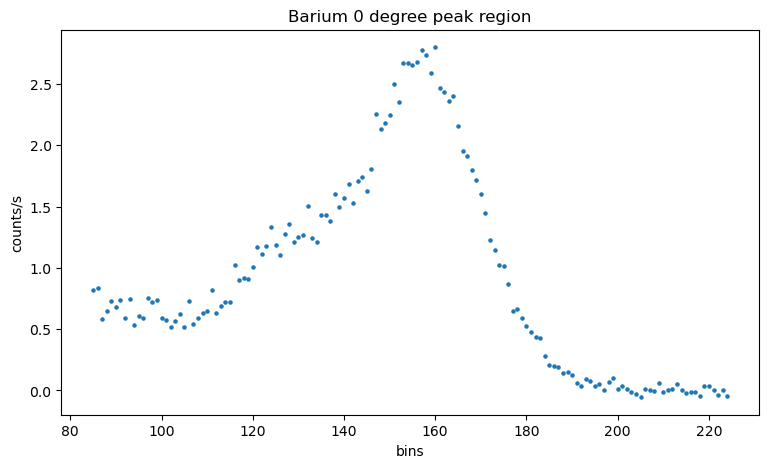

In [30]:
fig,ax = plt.subplots(figsize=(9,5))
ax.scatter(Ba_bins[85:225], Ba_0_cps[85:225],s=5)
ax.set_title('Barium 0 degree peak region')
ax.set_xlabel('bins')
ax.set_ylabel('counts/s')

In [31]:
peak_2_popt, peak_2_pcov = fit_compound_model(Ba_bins[85:225],Ba_0_cps[85:225])

In [32]:
background_y = ignore_peak(Ba_0_cps[85:225])
b_popt, b_pcov = curve_fit(quadratic, Ba_bins[85:225], background_y, p0 = None)
quad_fit = quadratic(np.array(Ba_bins[85:225]), *b_popt)

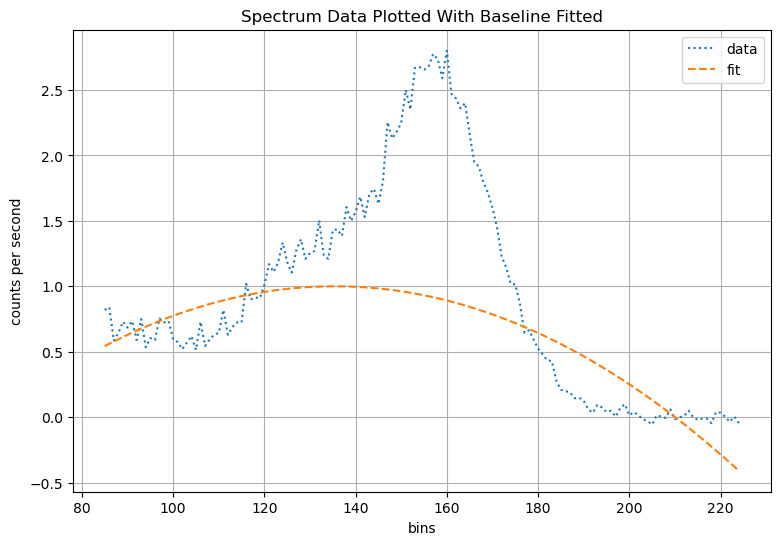

In [33]:
fig, ax = plt.subplots(figsize  = (9,6))
ax.set_title("Spectrum Data Plotted With Baseline Fitted")
ax.set_xlabel("bins")
ax.set_ylabel("counts per second")

ax.plot(Ba_bins[85:225], Ba_0_cps[85:225], ls = ":", label = "data")
ax.plot(Ba_bins[85:225], quad_fit, ls = '--', label = "fit")
ax.grid()
ax.legend()

Parameters: 

Baseline Polynomial Fit: 
a = -6.457669415419302e-05 +/- 1.9887452210348406e-05,
b = 0.012874067846217243 +/- 0.006172758484615808, 
c = 0.11335146183190407 +/- 0.42571775425088176
Gaussian Fit: 
mu0 = 155.66945476335576 +/- 0.3504197736774808,
sigma0 = 12.872048660636503 +/- 0.5244420039990936,
amp0 = 66.27015230274391 +/- 3.9338820259183063


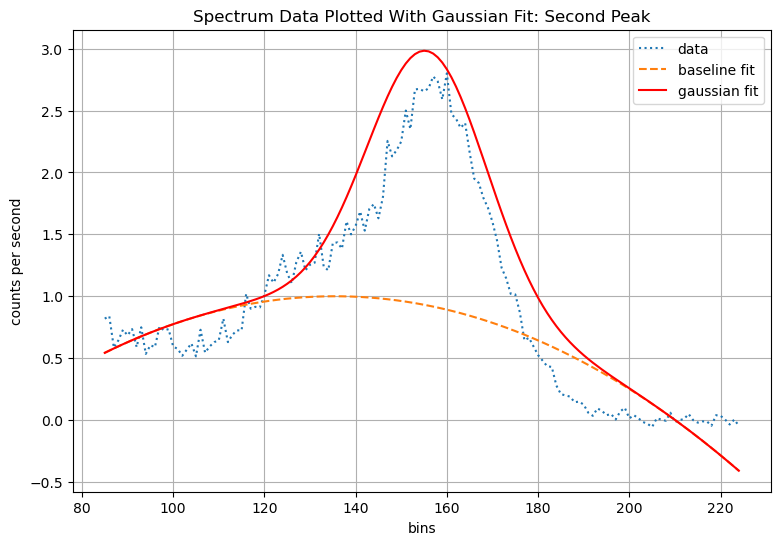

In [34]:
#fitting and plotting gauss model: 
popt, pcov = fit_compound_model(np.array(Ba_bins[85:225]), np.array(Ba_0_cps[85:225]))
#compound_fit = compound_model(np.array(spectrum_dict["Wavelength"]), *popt)
gauss_fit = gaussian(np.array(Ba_bins[85:225]), *popt[:3])
    
fig, ax = plt.subplots(figsize = (9,6))

ax.set_title("Spectrum Data Plotted With Gaussian Fit: Second Peak")
ax.set_xlabel("bins")
ax.set_ylabel("counts per second")

ax.plot(Ba_bins[85:225], Ba_0_cps[85:225], ls = ":", label = "data")
ax.plot(Ba_bins[85:225], quad_fit, ls = '--', label = "baseline fit")
#for some reason the line below works better than plotting compound model even though it should return the same thing?
ax.plot(Ba_bins[85:225], gauss_fit + quad_fit, ls = '-', color = 'r', label = "gaussian fit") 
ax.grid()
ax.legend()

#printing out parameters and uncertainties:
print_uncertainties(pcov, popt)

In [35]:
def gaussian_plotter(x,y):
    peak_popt, peak_pcov = fit_compound_model(x,y)
    background_y = ignore_peak(y)
    b_popt, b_pcov = curve_fit(quadratic, x, background_y, p0 = None)
    quad_fit = quadratic(np.array(x), *b_popt)
    popt, pcov = fit_compound_model(np.array(x), np.array(y))
    gauss_fit = gaussian(np.array(x), *popt[:3])

    fig, ax = plt.subplots(nrows = 3,figsize = (9,20))
    ax[0].scatter(x, y,s=5)
    ax[0].set_title('Barium 0 degree peak region')
    ax[0].set_xlabel('bins')
    ax[0].set_ylabel('counts/s')

    ax[1].set_title("Spectrum Data Plotted With Baseline Fitted")
    ax[1].set_xlabel("bins")
    ax[1].set_ylabel("counts per second")

    ax[1].plot(x, y, ls = ":", label = "data")
    ax[1].plot(x, quad_fit, ls = '--', label = "fit")
    ax[1].grid()
    ax[1].legend()

    ax[2].set_title("Spectrum Data Plotted With Gaussian Fit: Second Peak")
    ax[2].set_xlabel("bins")
    ax[2].set_ylabel("counts per second")

    ax[2].plot(x, y, ls = ":", label = "data")
    ax[2].plot(x, quad_fit, ls = '--', label = "baseline fit")

    ax[2].plot(x, gauss_fit + quad_fit, ls = '-', color = 'r', label = "gaussian fit") 
    ax[2].grid()
    ax[2].legend()

    return print_uncertainties(pcov, popt)

Parameters: 

Baseline Polynomial Fit: 
a = 0.0007037560180025403 +/- 8.445495733375647e-05,
b = -0.09126004036388354 +/- 0.009885247467648182, 
c = 3.7190017383708023 +/- 0.29274372001363985
Gaussian Fit: 
mu0 = 33.00213777070017 +/- 0.1507486017635693,
sigma0 = 5.1923378151231105 +/- 0.19495955520417355,
amp0 = 46.11191170358221 +/- 2.3229981616563085


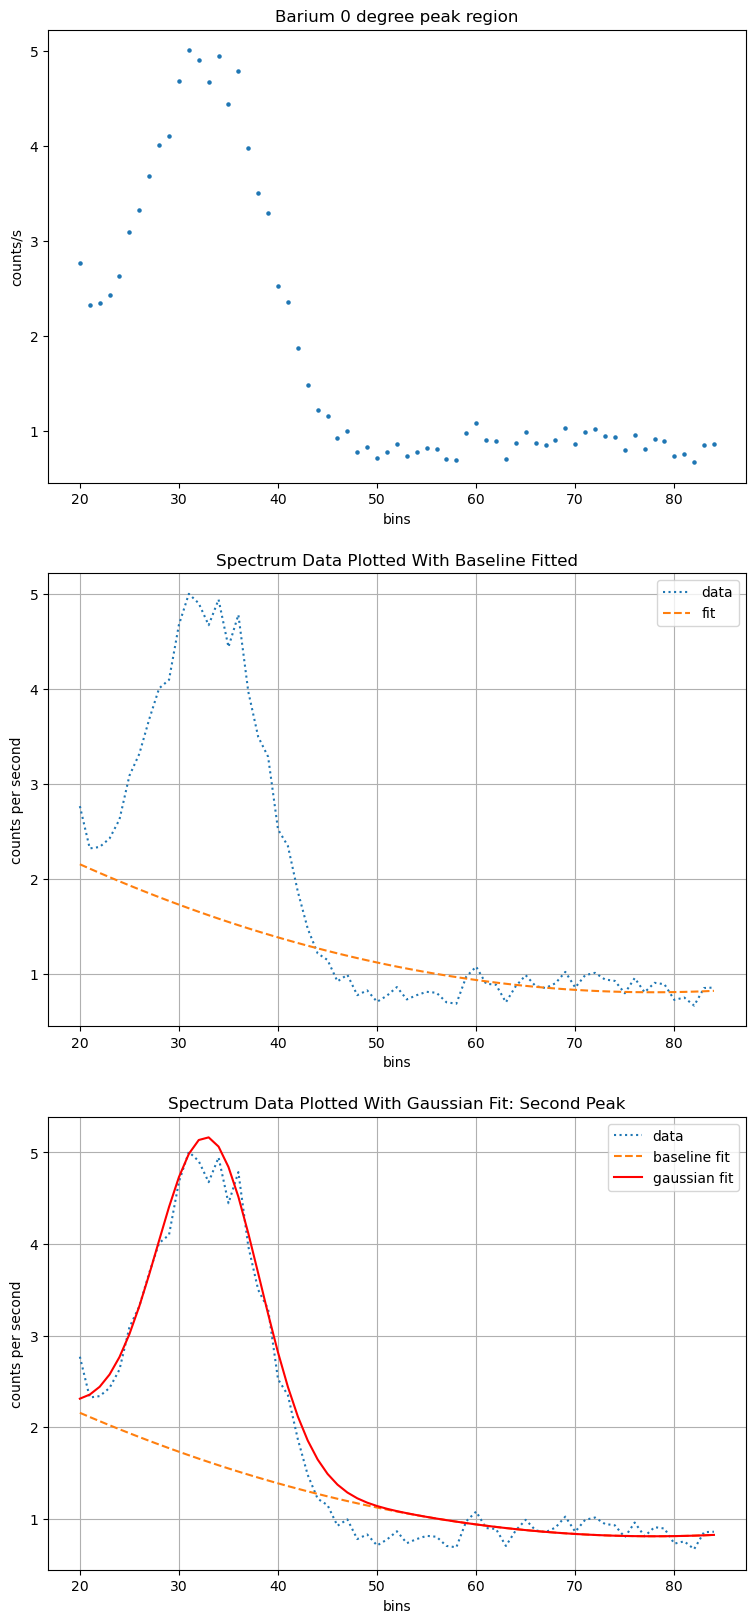

In [36]:
gaussian_plotter(Ba_bins[20:85],Ba_0_cps[20:85])

In [109]:
"""
def peak_finder(bins,counts):
    bins_range = bins[20:]
    counts_range = counts[20:]
    
    peaks = []
    for i in ROIs
        peak_init = max(counts_range[ROI[i]])
        index = int(np.argmax(counts_range==peak_init))
        
        if index < 30:
            check_range = range(0,index+30)
        else:
            check_range = range(index-30,index+30)
        for i in check_range:
            if counts_range[i] > peak_init:
                peak_max = count_range[i]
                index_max = int(np.argmax(counts_range == peak_max))
                peaks.append(peak_max)
            else:
                peak_max = peak_init
                index_max = index
                peaks.append(peak_max)

    return peaks
"""        

SyntaxError: invalid syntax (1030238119.py, line 4)

In [107]:
#peak_finder(Ba_bins, Ba_0_cps)

(np.float64(5.005), 11)

In [111]:
Co_header, Co_spec = file_parser("C:/Users/erisd/Desktop/Detector Lab/BGO Data/Co BGO.Spe")

Am_header, Am_spec = file_parser("C:/Users/erisd/Desktop/Detector Lab/BGO Data/AM BGO.Spe")

#Cs_header, Cs_spec = file_parser("C:/Users/erisd/Desktop/Detector Lab/BGO Data/Co BGO.Spe")

In [113]:
Co_cps, Co_bins = data_fetcher(Co_header,Co_spec)
Am_cps, Am_bins = data_fetcher(Am_header,Am_spec)

Text(0, 0.5, 'counts/s')

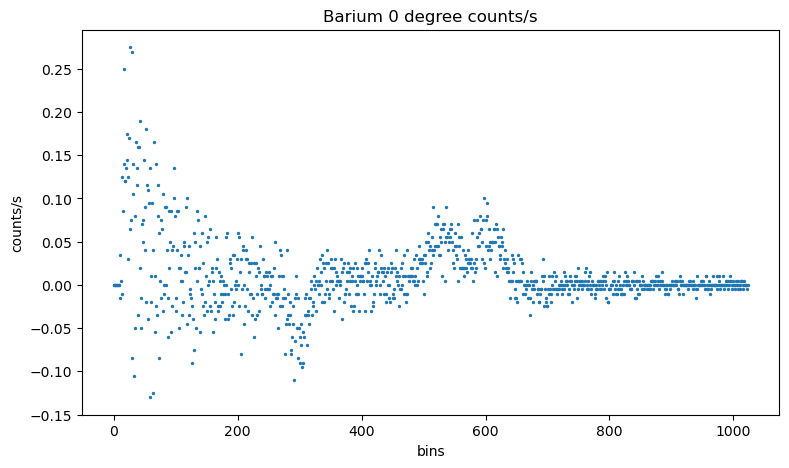

In [119]:
fig,ax = plt.subplots(figsize=(9,5))
ax.scatter(Co_bins, Co_cps,s=2)
#ax.scatter(background_spec['bins'],background_cps,color='orange', s = 2)
ax.set_title('Barium 0 degree counts/s')
ax.set_xlabel('bins')
ax.set_ylabel('counts/s')

Text(0, 0.5, 'counts/s')

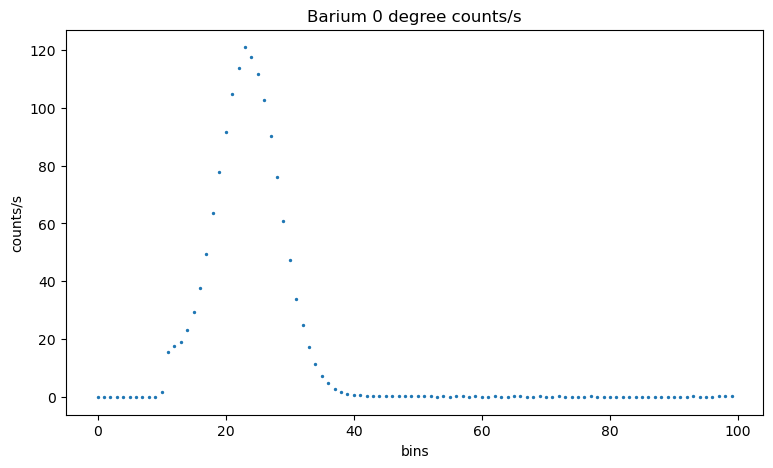

In [117]:
fig,ax = plt.subplots(figsize=(9,5))
ax.scatter(Am_bins[0:100], Am_cps[0:100],s=2)
#ax.scatter(background_spec['bins'],background_cps,color='orange', s = 2)
ax.set_title('Barium 0 degree counts/s')
ax.set_xlabel('bins')
ax.set_ylabel('counts/s')